# Fibonacci Retracement

This code is using the yfinance library to download historical stock data for a specified stock ticker symbol, then it does some data preprocessing, such as converting the date column to a datetime object, calculating the moving average and Fibonacci retracements, and then it splits the data into features (X) and target (y). After that, it uses the HistGradientBoostingRegressor from scikit-learn to fit the model with the data and make predictions for the next 30 days. Then it creates a dataframe with these predictions, calculates the standard deviation of the last year's close prices, and generates a plot to visualize the predictions, including the standard deviation as a range around the predictions.

Enter the stock ticker symbol or 'exit' to finish: GOOG


[*********************100%%**********************]  1 of 1 completed


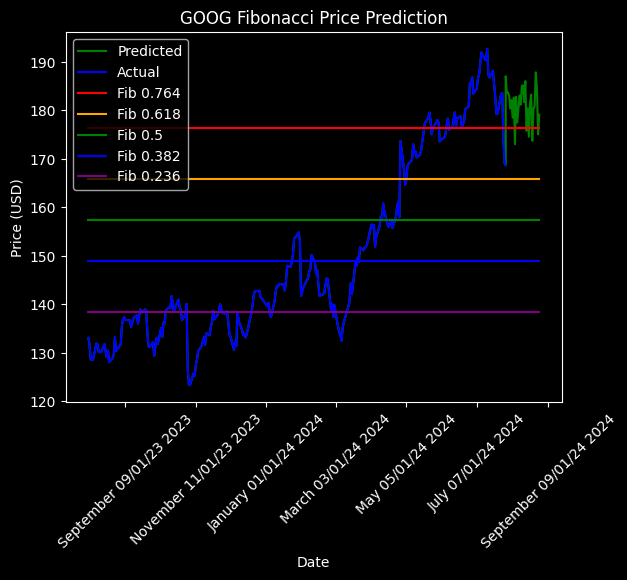

Enter the stock ticker symbol or 'exit' to finish: AAPL


[*********************100%%**********************]  1 of 1 completed


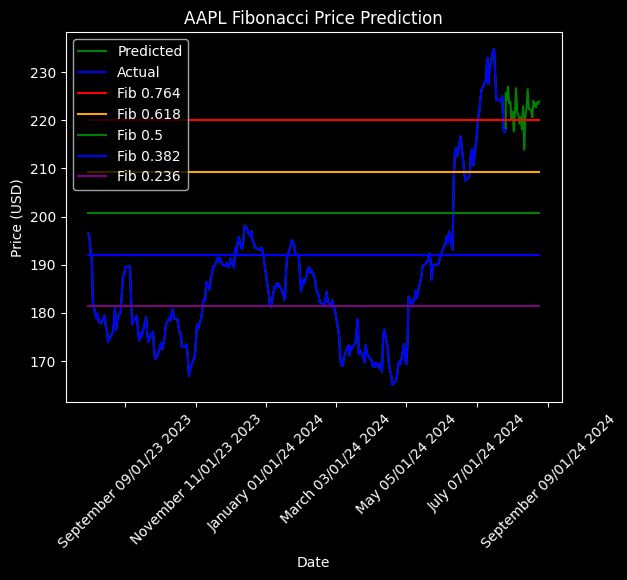

Enter the stock ticker symbol or 'exit' to finish: exit


In [1]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

while True:
    # Ask the user for the stock ticker symbol
    stock_ticker = input("Enter the stock ticker symbol or 'exit' to finish: ")
    if stock_ticker.lower() == 'exit':
        break

    # Get today's date
    today = datetime.datetime.now().date()

    # Subtract 365 days from today's date
    one_year_ago = today - datetime.timedelta(days=365)

    # Use the date one year ago as the start parameter in yf.download()
    data = yf.download(stock_ticker, start=one_year_ago)

    if data.empty:
        print("No data available for the stock ticker symbol:", stock_ticker, ". Please try another symbol.")
        continue
    else:
        # Convert the date column to a datetime object
        data['Date'] = pd.to_datetime(data.index)

        # Set the date column as the index
        data.set_index('Date', inplace=True)

        # Sort the data by date
        data.sort_index(inplace=True)

        # Get the data for the last year
        last_year = data.iloc[-365:].copy()

        # Calculate the moving average
        last_year.loc[:,'MA'] = last_year['Close'].rolling(window=20).mean()

        # Calculate the Fibonacci retracements
        high = last_year['High'].max()
        low = last_year['Low'].min()
        fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.764, 1]
        fib_values = []
        for level in fib_levels:
            fib_values.append(low + level * (high - low))

        # Add the Fibonacci levels to the dataframe
        last_year['Fib_0.236'] = fib_values[1]
        last_year['Fib_0.382'] = fib_values[2]
        last_year['Fib_0.5'] = fib_values[3]
        last_year['Fib_0.618'] = fib_values[4]
        last_year['Fib_0.764'] = fib_values[5]

        # Split the data into X (features) and y (target)
        X = last_year[['MA', 'Fib_0.236', 'Fib_0.382', 'Fib_0.5', 'Fib_0.618', 'Fib_0.764']]
        y = last_year['Close']

        # Create an HistGradientBoostingRegressor instance
        model = HistGradientBoostingRegressor()

        # Fit the model with the data
        model.fit(X, y)

        # Make predictions for the next 30 days
        future_dates = pd.date_range(start=data.index[-1], periods=30, freq='D')
        future_data = pd.DataFrame(index=future_dates, columns=['MA','Fib_0.236', 'Fib_0.382', 'Fib_0.5', 'Fib_0.618', 'Fib_0.764'])
        future_data['MA'] = last_year['MA'].iloc[-1]
        future_data['Fib_0.236'] = last_year['Fib_0.236'].iloc[-1]
        future_data['Fib_0.382'] = last_year['Fib_0.382'].iloc[-1]
        future_data['Fib_0.5'] = last_year['Fib_0.5'].iloc[-1]
        future_data['Fib_0.618'] = last_year['Fib_0.618'].iloc[-1]
        future_data['Fib_0.764'] = last_year['Fib_0.764'].iloc[-1]

        predictions = model.predict(future_data)
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Calculate the standard deviation of the last year's close prices
        std_dev = last_year['Close'].std()

        # Generate random values with a standard deviation of 0.5 * the last year's close prices standard deviation
        random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

        # Add the random values to the predicted prices
        predictions += random_values
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Concatenate the last_year and predictions dataframes
        predictions_df = pd.concat([last_year, predictions_df])

        # Recalculate Fibonacci retracements for the next 30 days
        high = predictions_df['High'].max()
        low = predictions_df['Low'].min()
        fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.764, 1]
        fib_values = []
        for level in fib_levels:
            fib_values.append(low + level * (high - low))

        predictions_df['Fib_0.236'] = fib_values[1]
        predictions_df['Fib_0.382'] = fib_values[2]
        predictions_df['Fib_0.5'] = fib_values[3]
        predictions_df['Fib_0.618'] = fib_values[4]
        predictions_df['Fib_0.764'] = fib_values[5]

        # Set the style to dark theme
        style.use('dark_background')

        # Create the plot
        fig, ax = plt.subplots()

        # Plot the predicted close prices for the next 30 days
        ax.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')

        # Plot the actual close prices
        ax.plot(last_year.index, last_year['Close'], color='blue', label='Actual')

        # Plot the Fibonacci retracements levels
        ax.plot(predictions_df.index, predictions_df['Fib_0.764'], color='red', label='Fib 0.764')
        ax.plot(predictions_df.index, predictions_df['Fib_0.618'], color='orange', label='Fib 0.618')
        ax.plot(predictions_df.index, predictions_df['Fib_0.5'], color='green', label='Fib 0.5')
        ax.plot(predictions_df.index, predictions_df['Fib_0.382'], color='blue', label='Fib 0.382')
        ax.plot(predictions_df.index, predictions_df['Fib_0.236'], color='purple', label='Fib 0.236')

        # Set x-axis as date format
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %D %Y"))
        plt.xticks(rotation=45)

        # Add labels and legend
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.title(stock_ticker.upper() + ' Fibonacci Price Prediction')
        plt.legend()

        # Show the plot
        plt.show()
